In [6]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
import skvideo.io
import tqdm

import matplotlib.pyplot as plt

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, BaggingRegressor)
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm_notebook as tqdm

In [7]:
def get_videos_from_folder(data_folder):
    '''
    get a list of video x wehre each video is a numpy array in the format [n_frames,width,height] 
    with uint8 elements.
    argument: relative path to the data_folder from the source folder.
    '''
    data_folder = os.path.join(dir_path,data_folder)
    x = []
    file_names = []
    
    if os.path.isdir(data_folder):
        for dirpath, dirnames, filenames in os.walk(data_folder):
            filenames = natsort.natsorted(filenames,reverse=False)
            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                statinfo = os.stat(file_path)
                if statinfo.st_size != 0:
                    video = skvideo.io.vread(file_path, outputdict={"-pix_fmt": "gray"})[:, :, :, 0]
                    x.append(video)
                    file_names.append(int(filename.split(".")[0]))

    indices = sorted(range(len(file_names)), key=file_names.__getitem__)
    x = np.take(x,indices)
    return x

def get_target_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of video. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path,csv_file)
    with open(csv_file, 'r') as csvfile:
        label_reader = pd.read_csv(csvfile)
        #print("Labels: ", label_reader['id'])
        y = label_reader['y']
        
    y = np.array(y)
    return y



def extract_features(videos):

    #Extracting features
    height_im = videos[0][0].shape[0]
    
    X_video_features = []
    
    for video in tqdm(videos):
        all_features = []
        n_parts = len(video)
        for part in video:
            feature_vec = []
            part_grad = np.diff(part,axis = 0) #frame-wise gradient
            height_im_grad = part_grad.shape[1]
            width_im_grad = part_grad.shape[2]

            # compute the sum of pixels per frame
            heartBeatApprox = np.sum(np.sum(part, axis=1), axis=1)
            feature_vec.append(np.min(heartBeatApprox))
            feature_vec.append(np.max(heartBeatApprox))
            feature_vec.append(np.mean(heartBeatApprox))
            feature_vec.append(np.std(heartBeatApprox))
            feature_vec += heartBeatApprox.tolist()


            for idx in range(height_im):
                feature_vec.append(np.mean(part[:,:,idx])) #entire video video mean_column_pixels            1
                feature_vec.append(np.mean(part[:,idx,:])) #entire video mean_row_pixels             2
                feature_vec.append(np.std(part[:,:,idx])) #entire video std_column_pixels            3
                feature_vec.append(np.std(part[:,idx,:])) #entire video std_row_pixels               4
                feature_vec.append(np.count_nonzero(part[:,:,idx])) #entire nonzero_column_pixels    5
                feature_vec.append(np.count_nonzero(part[:,idx,:])) #entire nonzero_row_pixels       6

            # ? TODO ? Taking some of the same previous features but just frame-wise?
            feature_vec.append(np.mean(part_grad)) #mean_video_grad    1
            feature_vec.append(np.std(part_grad)) #std_video_grad      2
            feature_vec.append(np.mean(part_grad)) #mean_frame_grad    3


            for frame_grad in part_grad:
                feature_vec.append(np.mean(frame_grad))
                feature_vec.append(np.std(frame_grad)) #Std of the gradient of the single frame std_frame_grad      1

                for idx in range(height_im_grad):            
                    feature_vec.append(np.mean(frame_grad[:,idx])) #mean_grad_column_pixels   1
                    feature_vec.append(np.mean(frame_grad[idx,:])) #mean_grad_row_pixels           2
                    feature_vec.append(np.std(frame_grad[:,idx])) #std_grad_column_pixels          3
                    feature_vec.append(np.std(frame_grad[idx,:])) #std_grad_row_pixels               4
                    feature_vec.append(np.count_nonzero(frame_grad[:,idx])) #nonzero_grad_column_pixels  5
                    feature_vec.append(np.count_nonzero(frame_grad[idx,:])) #nonzero_grad_row_pixels     6

            total_features = len(feature_vec)
            all_features.append(feature_vec)

        X_features = np.zeros((n_parts,total_features))

        for i in range(n_parts):
            X_features[i,:] = all_features[i]
        
        X_video_features.append(X_features)
    return np.concatenate([X_video_features])

def make_submission(filename, predictions):
    ids = extract_ids(test_folder)
    df = pd.DataFrame({'id':ids, 'y':predictions})
    df[["id", "y"]].to_csv("submissions/"+filename, index= False)
def split_into_parts(x_data, n_frames, y_data=None):

    height_im = x_data[0].shape[1]
    width_im = x_data[0].shape[2]
    
    videos = []
    video_ids = []
    video_labels = []
    
    n_videos = x_data.shape[0]

    for v_id in range(n_videos):
        video = x_data[v_id]
        if y_data is not None:
            label = y_data[v_id]
            
        n_subsamples = int(video.shape[0]/n_frames)
        parts = []
        parts_v_ids = []
        parts_labels = []
        
        for i in range(n_subsamples):
            from_frame = i*n_frames
            to_frame = from_frame + n_frames
            parts.append(video[from_frame:to_frame,:,:])
            parts_v_ids.append(v_id)
            
            if y_data is not None:
                parts_labels.append(label)
        
        
        
        
        videos.append(np.concatenate([parts]))
        video_ids.append(np.concatenate([parts_v_ids]))
        
        if y_data is not None:
            video_labels.append(np.concatenate([parts_labels]))
            
    X = np.concatenate([videos])
    v_idx = np.concatenate([video_ids])
    
    if y_data is not None:
        y = np.concatenate([video_labels])
        
        return X, v_idx, y
        
    else:
        return X, v_idx
    
def split_into_parts_with_sliding_window(x_data, n_frames, y_data=None):

    height_im = x_data[0].shape[1]
    width_im = x_data[0].shape[2]
    
    videos = []
    video_ids = []
    video_labels = []
    
    n_videos = x_data.shape[0]

    for v_id in range(n_videos):
        video = x_data[v_id]
        if y_data is not None:
            label = y_data[v_id]
            
        n_subsamples = int(video.shape[0] - n_frames)
        parts = []
        parts_v_ids = []
        parts_labels = []
        
        for i in range(n_subsamples):
            from_frame = i
            to_frame = from_frame + n_frames
            parts.append(video[from_frame:to_frame,:,:])
            parts_v_ids.append(v_id)
            
            if y_data is not None:
                parts_labels.append(label)
        
        videos.append(np.concatenate([parts]))
        video_ids.append(np.concatenate([parts_v_ids]))
        
        if y_data is not None:
            video_labels.append(np.concatenate([parts_labels]))
            
    X = np.concatenate([videos])
    v_idx = np.concatenate([video_ids])
    
    if y_data is not None:
        y = np.concatenate([video_labels])
        
        return X, v_idx, y
        
    else:
        return X, v_idx
    


def combine_parts_pred(y_pred, v_idx):
    d = {}
    for v_id, pred in zip(v_idx, y_pred):
        if v_id not in d:
            d[v_id] = []
        
        d[v_id].append(pred)
        
    
    results = []
    for v_id, preds in d.items():
        results.append({"id":v_id,"y":sum(preds) / float(len(preds))})
    
    df = pd.DataFrame(results)
    return df
    


In [8]:
seed=42
np.random.seed(seed)
rn.seed(seed)
dir_path = os.getcwd()

train_folder = os.path.join(dir_path,"data/train/")
test_folder = os.path.join(dir_path,"data/test/")

train_target = os.path.join(dir_path,'data/train_target.csv')

print("Current dir -> ", dir_path)
print("Train folder -> ",train_folder)
print("Train target -> ",train_target)
print("Test folder -> ",test_folder)

#Load data from csv file
print("Train Data\n")
x_train = get_videos_from_folder(train_folder) #List of numpy arrays
y_train = get_target_from_csv(train_target) #Numpy array of labels
print("Test Data\n")
x_test = get_videos_from_folder(test_folder) #List of numpy arrays

Current dir ->  /home/ax/master/2018_02/ml/task4
Train folder ->  /home/ax/master/2018_02/ml/task4/data/train/
Train target ->  /home/ax/master/2018_02/ml/task4/data/train_target.csv
Test folder ->  /home/ax/master/2018_02/ml/task4/data/test/
Train Data

Test Data



In [23]:
rf = RandomForestRegressor(n_estimators=500,
                                       random_state=seed,
                                       n_jobs=-1,
                                       verbose=1)

gb = GradientBoostingRegressor(random_state=seed,
                                       n_estimators=100,
                                       max_depth=5,
                                       verbose=1,
                                       learning_rate=0.1)

classifiers = [rf, gb]
classifiers_names = ["RandomForestRegressor", "GradientBoostingRegressor"]

In [20]:
n_frames = 20


print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")

scaler = StandardScaler()

print("Splitting videos into parts...")
x_train_parts, train_idx_parts, y_train_parts = split_into_parts_with_sliding_window(x_data=x_train, n_frames=n_frames, y_data=y_train)



print("Extracting features from parts...")
x_train_parts_features = extract_features(x_train_parts)

print(f"xtrain_parts_features: {x_train_parts_features.shape}")
print(f"xtrain_parts_features[0]: {x_train_parts_features[0].shape}")

x_train_parts_features_unrolled = np.concatenate(x_train_parts_features)
print(f"Unrolled: {x_train_parts_features_unrolled.shape}")

print("Fitting Standard Scalar...")
scaler.fit(x_train_parts_features_unrolled)

x_train: (158,)
y_train: (158,)
x_test: (69,)
Splitting videos into parts...
Extracting features from parts...


xtrain_parts_features: (158,)
xtrain_parts_features[0]: (57, 11585)
Unrolled: (7150, 11585)
Fitting Standard Scalar...


StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
# Create a feature selctor base on a random forest
sfm = SelectFromModel(RandomForestClassifier(n_estimators=2000, random_state=seed, n_jobs=-1, verbose=1), threshold=0.0001)

# Train the classifier

sfm.fit(x_train_parts_features_unrolled, np.concatenate(y_train_parts))
print(f"Using: {np.sum(sfm.get_support())} features")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.2min finished


Using: 1984 features


In [13]:
print(f"Class 0: {np.sum(np.concatenate(y_train_parts) == 0)}")
print(f"Class 1: {np.sum(np.concatenate(y_train_parts) == 1)}")

Class 0: 3010
Class 1: 3824


In [24]:
seed = 42
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

clf_scores_parts_avg = []
clf_scores_parts_std = []

clf_scores_video_avg = []
clf_scores_video_std = []

verbose = False


roc_auc_parts_scores = []
roc_auc_video_scores = []
roc_auc_parts_scores_gb = []
roc_auc_video_scores_gb = []
roc_auc_parts_scores_avg = []
roc_auc_video_scores_avg = []


print("Start")
for train, valid in tqdm(kfold.split(x_train_parts_features , y_train)):
    #for clf in tqdm(classifiers, desc="Classifier: "):
    # split training set into parts
    x_train_fold = x_train_parts_features[train]
    y_train_fold = y_train_parts[train] 

    # split validation set into parts
    x_valid_fold = x_train_parts_features[valid]
    y_valid_fold = y_train_parts[valid]
    y_valid_fold_videos = y_train[valid]
    idx_valid_fold = train_idx_parts[valid]

    # unrolling from [video id, part idx, feature] to [part idx, feature]
    x_train_fold_unrolled = np.concatenate(x_train_fold)
    y_train_fold_unrolled = np.concatenate(y_train_fold)

    x_valid_fold_unrolled = np.concatenate(x_valid_fold)
    y_valid_fold_unrolled = np.concatenate(y_valid_fold)
    idx_valid_fold_unrolled = np.concatenate(idx_valid_fold)

    if verbose:
        print(f"x_train_fold: {x_train_fold.shape}")
        print(f"y_train_fold: {y_train_fold.shape}")
        print(f"x_train_fold_unrolled: {x_train_fold_unrolled.shape}")
        print(f"y_train_fold_unrolled: {y_train_fold_unrolled.shape}")

        print(f"x_valid_fold: {x_valid_fold.shape}")
        print(f"y_valid_fold: {y_valid_fold.shape}")
        print(f"idx_valid_fold: {idx_valid_fold.shape}")
        print(f"x_valid_fold_unrolled: {x_valid_fold_unrolled.shape}")
        print(f"y_valid_fold_unrolled: {y_valid_fold_unrolled.shape}")
        print(f"idx_valid_fold_unrolled: {idx_valid_fold_unrolled.shape}")

    # scale the extracted features to zero mean and unit variance 
    x_train_fold_scaled = scaler.transform(x_train_fold_unrolled)
    x_valid_fold_scaled = scaler.transform(x_valid_fold_unrolled)

    # Shuffle the training data
    indices = np.arange(x_train_fold_scaled.shape[0])
    np.random.shuffle(indices)
    x_train_fold_scaled = x_train_fold_scaled[indices]
    y_train_fold_unrolled = y_train_fold_unrolled[indices]
    
    # use only important features only RF
    X_important_train = sfm.transform(x_train_fold_scaled)
    X_important_valid = sfm.transform(x_valid_fold_scaled)

    # fit classifier
    rf.fit(X_important_train, y_train_fold_unrolled)
    #gb.fit(x_train_fold_scaled_gb, y_train_fold_unrolled_gb)
    gb.fit(X_important_train, y_train_fold_unrolled)

    y_valid_fold_pred = rf.predict(X_important_valid)
    #y_valid_fold_pred = rf.predict(x_valid_fold_scaled_gb)
    #y_valid_fold_pred_gb = gb.predict(x_valid_fold_scaled_gb)
    y_valid_fold_pred_gb = gb.predict(X_important_valid)

    # calculate the roc auc based on per part predictions
    roc_auc_parts = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_valid_fold_pred)
    roc_auc_parts_scores.append(roc_auc_parts)
    print(f"roc auc parts: {roc_auc_parts}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_valid_fold_pred, v_idx=idx_valid_fold_unrolled)
    roc_auc_video = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores.append(roc_auc_video)
    print(f"roc auc video: {roc_auc_video}")
        
    # calculate the roc auc based on per part predictions
    roc_auc_parts_gb = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_valid_fold_pred_gb)
    roc_auc_parts_scores_gb.append(roc_auc_parts_gb)
    print(f"roc auc part GBs: {roc_auc_parts_gb}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_valid_fold_pred_gb, v_idx=idx_valid_fold_unrolled)
    roc_auc_video_gb = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores_gb.append(roc_auc_video_gb)
    print(f"roc auc video GB: {roc_auc_video_gb}")
    
    # Combined approach
    y_combine_pred = (y_valid_fold_pred + y_valid_fold_pred_gb) / 2.0
    # calculate the roc auc based on per part predictions
    roc_auc_parts_avg = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_combine_pred)
    roc_auc_parts_scores_avg.append(roc_auc_parts_avg)
    print(f"roc auc part AVG: {roc_auc_parts_avg}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_combine_pred, v_idx=idx_valid_fold_unrolled)
    roc_auc_video_avg = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores_avg.append(roc_auc_video_avg)
    print(f"roc auc video AVG: {roc_auc_video_avg}")
    
        
    print("========================================")

print(f"Random forest roc_auc parts avg score {np.mean(roc_auc_parts_scores)} +/- {np.std(roc_auc_parts_scores)} roc_auc video avg score {np.mean(roc_auc_video_scores)} +/- {np.std(roc_auc_video_scores)}")
print(f"Gradient boosting roc_auc parts avg score {np.mean(roc_auc_parts_scores_gb)} +/- {np.std(roc_auc_parts_scores_gb)} roc_auc video avg score {np.mean(roc_auc_video_scores_gb)} +/- {np.std(roc_auc_video_scores_gb)}")
print(f"Combined roc_auc parts avg score {np.mean(roc_auc_parts_scores_avg)} +/- {np.std(roc_auc_parts_scores_avg)} roc_auc video avg score {np.mean(roc_auc_video_scores_avg)} +/- {np.std(roc_auc_video_scores_avg)}")


Start


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


      Iter       Train Loss   Remaining Time 
         1           0.2138            1.90m
         2           0.1863            1.90m
         3           0.1649            1.94m
         4           0.1470            1.91m
         5           0.1341            1.87m
         6           0.1214            1.88m
         7           0.1114            1.87m
         8           0.1024            1.86m
         9           0.0900            1.87m
        10           0.0799            1.87m
        20           0.0305            1.73m
        30           0.0169            1.48m
        40           0.0099            1.27m
        50           0.0055            1.07m
        60           0.0036           51.35s
        70           0.0026           37.94s
        80           0.0020           25.07s
        90           0.0015           12.45s
       100           0.0012            0.00s
roc auc parts: 0.5043175863299646
roc auc video: 0.484375
roc auc part GBs: 0.7037665717842251
roc 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


      Iter       Train Loss   Remaining Time 
         1           0.2177            1.65m
         2           0.1947            1.64m
         3           0.1721            1.76m
         4           0.1532            1.78m
         5           0.1351            1.81m
         6           0.1218            1.84m
         7           0.1057            1.88m
         8           0.0941            1.87m
         9           0.0847            1.88m
        10           0.0734            1.88m
        20           0.0273            1.73m
        30           0.0128            1.51m
        40           0.0060            1.32m
        50           0.0039            1.08m
        60           0.0025           52.00s
        70           0.0018           38.60s
        80           0.0014           25.44s
        90           0.0011           12.40s
       100           0.0008            0.00s
roc auc parts: 0.37483012728490767
roc auc video: 0.4375
roc auc part GBs: 0.2915239097840303
roc a

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.6min finished


      Iter       Train Loss   Remaining Time 
         1           0.2219            1.57m
         2           0.1916            1.85m
         3           0.1619            2.00m
         4           0.1438            2.02m
         5           0.1232            2.05m
         6           0.1061            2.06m
         7           0.0955            2.05m
         8           0.0828            2.05m
         9           0.0752            2.02m
        10           0.0661            2.01m
        20           0.0228            1.80m
        30           0.0111            1.53m
        40           0.0054            1.32m
        50           0.0035            1.08m
        60           0.0025           51.49s
        70           0.0018           39.10s
        80           0.0013           25.79s
        90           0.0010           12.93s
       100           0.0008            0.00s
roc auc parts: 0.37835224005436774
roc auc video: 0.625
roc auc part GBs: 0.47414919755345286
roc a

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.7min finished


      Iter       Train Loss   Remaining Time 
         1           0.2182            2.28m
         2           0.1955            2.02m
         3           0.1750            1.95m
         4           0.1558            2.05m
         5           0.1395            2.15m
         6           0.1222            2.23m
         7           0.1118            2.16m
         8           0.0960            2.17m
         9           0.0828            2.17m
        10           0.0722            2.16m
        20           0.0325            1.88m
        30           0.0151            1.69m
        40           0.0085            1.45m
        50           0.0053            1.19m
        60           0.0038           55.51s
        70           0.0028           40.55s
        80           0.0021           26.68s
        90           0.0016           13.21s
       100           0.0013            0.00s
roc auc parts: 0.8796931889334663
roc auc video: 0.828125
roc auc part GBs: 0.801593191252522
roc a

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.4min finished


      Iter       Train Loss   Remaining Time 
         1           0.2114            1.95m
         2           0.1814            1.92m
         3           0.1584            1.90m
         4           0.1362            1.89m
         5           0.1211            1.87m
         6           0.1053            1.87m
         7           0.0924            1.88m
         8           0.0841            1.84m
         9           0.0763            1.81m
        10           0.0663            1.82m
        20           0.0216            1.78m
        30           0.0108            1.59m
        40           0.0061            1.35m
        50           0.0038            1.12m
        60           0.0025           53.56s
        70           0.0018           39.58s
        80           0.0014           25.98s
        90           0.0011           12.85s
       100           0.0009            0.00s
roc auc parts: 0.657409381663113
roc auc video: 0.609375
roc auc part GBs: 0.7060573754603605
roc a

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.2min finished


      Iter       Train Loss   Remaining Time 
         1           0.2142            1.81m
         2           0.1916            1.72m
         3           0.1676            1.79m
         4           0.1436            1.88m
         5           0.1252            1.91m
         6           0.1080            1.94m
         7           0.0964            1.94m
         8           0.0837            1.94m
         9           0.0741            1.94m
        10           0.0647            1.94m
        20           0.0214            1.80m
        30           0.0099            1.59m
        40           0.0052            1.37m
        50           0.0034            1.12m
        60           0.0022           53.75s
        70           0.0016           39.58s
        80           0.0012           26.11s
        90           0.0010           12.84s
       100           0.0007            0.00s
roc auc parts: 0.6552474757157465
roc auc video: 0.546875
roc auc part GBs: 0.610804895194274
roc a

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.4min finished


      Iter       Train Loss   Remaining Time 
         1           0.2147            1.61m
         2           0.1831            1.69m
         3           0.1586            1.71m
         4           0.1397            1.71m
         5           0.1218            1.73m
         6           0.1074            1.71m
         7           0.0945            1.70m
         8           0.0832            1.68m
         9           0.0744            1.66m
        10           0.0657            1.66m
        20           0.0260            1.51m
        30           0.0133            1.33m
        40           0.0080            1.11m
        50           0.0052           53.98s
        60           0.0035           42.44s
        70           0.0023           31.74s
        80           0.0018           20.63s
        90           0.0014           10.17s
       100           0.0011            0.00s
roc auc parts: 0.697046664027796
roc auc video: 0.703125
roc auc part GBs: 0.648628886836434
roc au

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.5min finished


      Iter       Train Loss   Remaining Time 
         1           0.2153            1.68m
         2           0.1843            1.79m
         3           0.1599            1.81m
         4           0.1386            1.83m
         5           0.1209            1.88m
         6           0.1070            1.90m
         7           0.0942            1.91m
         8           0.0847            1.91m
         9           0.0749            1.91m
        10           0.0662            1.90m
        20           0.0214            1.66m
        30           0.0100            1.43m
        40           0.0055            1.19m
        50           0.0034           58.28s
        60           0.0024           45.43s
        70           0.0018           33.21s
        80           0.0014           21.74s
        90           0.0010           10.81s
       100           0.0008            0.00s
roc auc parts: 0.37629430218977333
roc auc video: 0.46875
roc auc part GBs: 0.45973718529536534
roc

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


      Iter       Train Loss   Remaining Time 
         1           0.2152            1.99m
         2           0.1856            2.13m
         3           0.1617            2.15m
         4           0.1403            2.17m
         5           0.1230            2.24m
         6           0.1082            2.24m
         7           0.0952            2.26m
         8           0.0867            2.24m
         9           0.0759            2.22m
        10           0.0668            2.23m
        20           0.0236            2.07m
        30           0.0101            1.83m
        40           0.0058            1.53m
        50           0.0038            1.24m
        60           0.0028           57.58s
        70           0.0020           42.09s
        80           0.0016           27.63s
        90           0.0012           13.67s
       100           0.0010            0.00s
roc auc parts: 0.5209544670118147
roc auc video: 0.59375
roc auc part GBs: 0.6497809637594585
roc a

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.8min finished


      Iter       Train Loss   Remaining Time 
         1           0.2201            1.67m
         2           0.1973            1.72m
         3           0.1728            1.85m
         4           0.1572            1.84m
         5           0.1418            1.84m
         6           0.1214            1.92m
         7           0.1045            1.97m
         8           0.0968            1.93m
         9           0.0873            1.93m
        10           0.0763            1.95m
        20           0.0277            1.83m
        30           0.0120            1.60m
        40           0.0071            1.33m
        50           0.0041            1.11m
        60           0.0031           52.28s
        70           0.0022           38.75s
        80           0.0017           25.52s
        90           0.0014           12.62s
       100           0.0011            0.00s
roc auc parts: 0.5891364421416234
roc auc video: 0.5102040816326531
roc auc part GBs: 0.57709844559

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


In [17]:
# unrolling from [video id, part idx, feature] to [part idx, feature]
x_train_unrolled = np.concatenate(x_train_parts_features)    
y_train_unrolled = np.concatenate(y_train_parts)


# scale the extracted features to zero mean and unit variance 
x_train_scaled = scaler.transform(x_train_unrolled)

# use only important features only RF
X_important_train = sfm.transform(x_train_scaled)
    
# fit classifier
rf.fit(X_important_train, y_train_unrolled)
    

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=False,
           warm_start=False)

,id,y
0,0,0.424500
1,1,0.284500
2,2,0.549667
3,3,0.682250
4,4,0.536750
5,5,0.510250
6,6,0.695000
7,7,0.721833
8,8,0.435000
9,9,0.419750


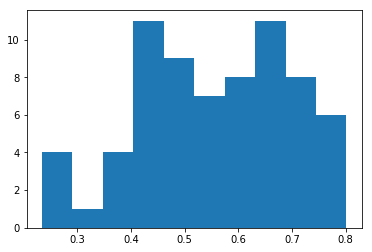

In [18]:


# split videos in parts of 22 frames 
x_test_parts, test_idx_parts = split_into_parts(x_data=x_test, n_frames=n_frames)

# extract features for each part
x_test_parts_features = extract_features(x_test_parts)

# unroll [video, part_id, features] to [part_id, features]
x_test_parts_features_unrolled = np.concatenate(x_test_parts_features)
test_idx_parts_unrolled = np.concatenate(test_idx_parts)

# scale data
x_test_scaled = scaler.transform(x_test_parts_features_unrolled)

# pick importanted features
# use only important features only RF
X_important_test = sfm.transform(x_test_scaled)
    
    
# predict 
y_test_pred = rf.predict(X_important_test)

# combine preidctions of multiple parts per video into single prediction by averaging
df = combine_parts_pred(y_pred=y_test_pred, v_idx=test_idx_parts_unrolled)

display(df)
plt.hist(df['y'], bins=25)
plt.show()
df.to_csv("submissions/rf_combined.csv", index= False)